<div style="max-width: 900px; position: relative; margin: auto"><h1 style="text-align: center">Image Recognition – Classifying images from CIFAR-10 dataset</h1><p style="text-align: right; padding-right: 3em; color: #8c8c8c;"><i>Šimon Varga, Michal Barnišin</i></p></div>

# Introduction

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of tiny coloured images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton and are available [here](https://www.cs.toronto.edu/~kriz/cifar.html). For further information, please see [the official tech report](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).

In this project, we will try to classify CIFAR-10 dataset images, using a simple classifier, by which we mean not neural networks. Our aim is to maximize accuracy. Therefore and with respect to the nature of this dataset, we will use the k-Nearest Neighbours model and Support Vector Machines.

We will try two different approaches to pre-processing, and we will evaluate the results for both models. Eventually, we will compare the models with respect to accuracy (mainly), and also the time needed for predictions and training.

All times presented in this script were measured on Intel core i7-7700HQ, 3.60GHz

## Data Loading and Environment Preparation

Given that the unzipped data (5 train batches, test batch and label metadata) are located in the folder marked as *CIFAR_DEFAULT_PATH*, the following script will load all train batches and test batch.

In [1]:
import numpy as np


# set random number generator seed
np.random.seed(0)

# The path with extracted files
CIFAR_DEFAULT_PATH = '../dataset'


def unpickle(path):
    """
    Loads data from file as is suggested on original cifar website

    :param path: name of file to read
    :return: dict (format specified in global docs)
    """
    import pickle
    with open(path, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict


def read_data_batch(i, path=CIFAR_DEFAULT_PATH):
    """
    Load and process data-batch file.

    :param i: which batch to load
    :param path: path to folder with file
    :return: tuple (imgs, labels) of np.arrays 
        (note: integer labels)
    """
    batch = unpickle(path + '/data_batch_' + str(i))
    return batch[b'data'], np.array(batch[b'labels'])


def read_test_batch(path=CIFAR_DEFAULT_PATH):
    """
    Load and process test file.

    :param path: path to folder with file
    :return: tuple (imgs, labels) of np.arrays 
        (note: integer labels)
    """
    batch = unpickle(path + '/test_batch')
    return batch[b'data'], np.array(batch[b'labels'])


def read_meta(path=CIFAR_DEFAULT_PATH):
    """
    Loads and returns CIFAR10 label names in order, i.e.
    to label 0, 0-th string name corresponds.

    :param path: path to meta folder
    :return: np.array of label names (of type np.bytes_)
    """
    return np.array(
        unpickle(path + '/batches.meta')[b'label_names']
    )

In [2]:
# Load train data
train_data, train_labels = [], []
for i in range(1, 6):
    imgs, labels = read_data_batch(i)
    train_data.append(imgs)
    train_labels.append(labels)
    
train_data = np.concatenate(train_data, axis=0)
train_labels = np.concatenate(train_labels, axis=0)
del imgs, labels

# Load test data
test_data, test_labels = read_test_batch()

# Load label names
label_names = read_meta()
label_names = list(map(np.bytes_.decode, label_names))

# Exploratory Analysis

In this section, we examine the shape of data, print random samples as well as examine some other properties of the data including correlation matrix and pictures similarity across the different classes.

Now, the dimensions and samples from data will be printed to discover the shape of the data.

In [3]:
print(f"Train data shape:\t{train_data.shape}")

Train data shape:	(50000, 3072)


So we have 50,000 train images (image per row), each row of the array stores a 32x32 colour image (as specified on the URL above). The first 1,024 entries contain the red channel values, the next 1,024 the green, and the final 1,024 the blue. The image is stored in row-major order so that the first 32 entries of the array are the red channel values of the first row of the image. The classes are completely mutually exclusive.

In [4]:
print(f"Test data shape:  {test_data.shape}")

Test data shape:  (10000, 3072)


The test batch contains exactly 1,000 images. They are declared to be picked randomly and shuffled, with no overlap with the training set.

In [5]:
display(train_data)
display(test_data)

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 35,  40,  42, ...,  77,  66,  50],
       [189, 186, 185, ..., 169, 171, 171],
       [229, 236, 234, ..., 173, 162, 161]], dtype=uint8)

array([[158, 159, 165, ..., 124, 129, 110],
       [235, 231, 232, ..., 178, 191, 199],
       [158, 158, 139, ...,   8,   3,   7],
       ...,
       [ 20,  19,  15, ...,  50,  53,  47],
       [ 25,  15,  23, ...,  80,  81,  80],
       [ 73,  98,  99, ...,  94,  58,  26]], dtype=uint8)

Furthermore, all values are stored as *uint8* which means, that the range is always valid (0-255), and data don't contain any missing values.

In [6]:
display(train_labels)
min(train_labels), max(train_labels)

array([6, 9, 9, ..., 9, 1, 1])

(0, 9)

Data are labelled with numbers in the range 0-9. String representations of labels are:

In [7]:
for i in range(0, 10):
    print(f"{i}\t{label_names[i]}")

0	airplane
1	automobile
2	bird
3	cat
4	deer
5	dog
6	frog
7	horse
8	ship
9	truck


## Classes distribution over train set and test set

To examine the classes distribution, we will plot the number of images per each class.

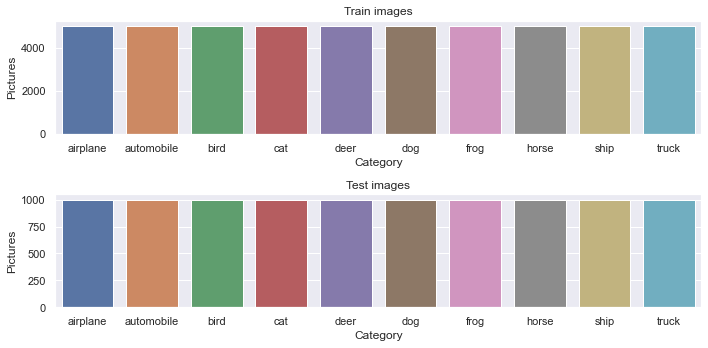

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_category_dist(labels):
    """
    Plots the distribution of values in *labels* as sns.barplot()
    :param labels labels of the data
    :return barplot with plotted data
    """
    bins = [np.count_nonzero(labels == cat) for cat in range(10)]
    frame = pd.DataFrame(data={
        "Category": label_names,
        "Pictures": bins
    })
    return sns.barplot(x="Category", y="Pictures", data=frame)


sns.set()
plt.figure(figsize=(10, 5))

# Distribution of train images
plt.subplot(2, 1, 1)
plot_category_dist(train_labels).set_title("Train images")

# Distribution of test images
plt.subplot(2, 1, 2)
plot_category_dist(test_labels).set_title("Test images")
plt.tight_layout()

From which we conclude, that all categories are equally present, so there is no need to weight the categories or add/remove samples.

## Pictures overview

Now, we will print one picture from each category.

In [9]:
def batch_to_rgb(images):
    """
    Given loaded image(s) from CIFAR-10 dataset (i.e. 32x32 values
    of red, then green and blue), returns same (set of) image(s) 
    with color channel being the last, i.e. batch_to_rgb[n][y][x] 
    returns 3-value array with r, g, b of pixel (x, y) of n-th 
    image.

    :param images: CIFAR-image(s) in default format
    :return: same image(s) with transformed colors to rgb
    """
    if len(images.shape) == 1:
        return images.reshape((3, 32, 32)).transpose(1, 2, 0)
    return images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)


def plot_raw_img(raw_img, label, ax, fontsize = 'medium'):
    """
    Plots single image on specified ax (see Axes).

    :param raw_img: format as in batch (1D array [R, G, B])
    :param label: integer label (None for no title)
    :param ax: ax to plot on
    :param fontsize: passed to ax.set_title
    """
    ax.imshow(batch_to_rgb(raw_img))
    if label is not None:
        ax.set_title(f"{label}: {label_names[label]}", 
                     fontsize=fontsize)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

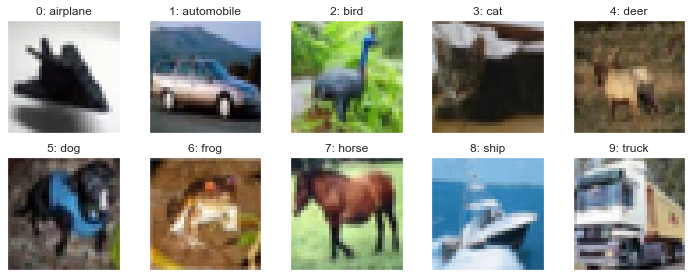

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs.ravel()):
    img = train_data[train_labels == i][0]
    plot_raw_img(img, i, ax)
plt.tight_layout()
plt.show();

## Class Similarities

To gain initial insights about the classes similarities, we examine the random or average picture for each category with its RGB and HSV histogram.

In [11]:
def img_for_show(raw_img: np.ndarray) -> np.ndarray:
    """
    Creates new image prepared to show from raw data from batch.

    :param raw_img: 1D format of image
    :return: 3D format (y, x, rgb) ready for pyplot's imshow
    """
    return raw_img.reshape((32, 32, 3), order='F').swapaxes(0, 1)


def plot_rgb_hist(raw_imgs, ax, **kwargs):
    """
    Plots histograms of image(s)'s R, G, B amount using seaborn

    :param raw_imgs: array of images (1D format) or one image
    :param ax: ax on which to plot
    :param kwargs: passed to seaborn.distplot
    """
    r = raw_imgs.reshape((-1, 3072))[:, :1024].reshape(-1)
    g = raw_imgs.reshape((-1, 3072))[:, 1024:2048].reshape(-1)
    b = raw_imgs.reshape((-1, 3072))[:, 2048:].reshape(-1)
    sns.distplot(r, color='red', ax=ax, **kwargs)
    sns.distplot(g, color='green', ax=ax, **kwargs)
    sns.distplot(b, color='blue', ax=ax, **kwargs)
    
    
def imgs_of_cat(batch, category: int) -> np.ndarray:
    """
    :param batch: From where to obtain images
    :param category: Images of what category to obtain
    :return: np.array of all images of specific category 
        (e.i. label) 
    """
    return batch[b'data'][np.array(batch[b'labels']) == category]


def plot_avg_imgs(batch, with_histogram = True, with_hsv = False):
    """
    Plot average image and optionally also histogram of RGB values
    for each category.

    :param batch: dictionary with images and labels
    :param with_histogram: whether to plot also histograms
    :param with_hsv: transform avg image to hsv and plot histogram
    :return: np.array of average images (in raw ravel form)
    """
    import matplotlib.colors as colors
    d = 0
    if with_histogram:
        d += 1
    if with_hsv:
        d += 1
        
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    nrows = 2 * (1 + d)
    fig, axs = plt.subplots(nrows, 5, figsize=(15, 10))
    hist_kws = {'range': (50, 200)}
    avg_imgs = []
    
    for i in range(10):
        imgs = imgs_of_cat(batch, i)
        avg_img = np.mean(imgs, axis=0)
        avg_imgs.append(avg_img)
        x, y = i % 5, i // 5
        y *= (1 + d)
    
        plot_raw_img(avg_img.astype('int'), i, axs[y][x])
        if with_histogram:
            y += 1
            plot_rgb_hist(avg_img, axs[y][x], hist_kws=hist_kws)
        if with_hsv:
            y += 1
            hsv_avg_img = colors.rgb_to_hsv(
                img_for_show(avg_img / 255)
            )
            sns.distplot(hsv_avg_img[:,:, 0].reshape(-1), color='r',
                         label='hue', ax=axs[y][x])
            sns.distplot(hsv_avg_img[:,:, 1].reshape(-1), color='y',
                         label='saturation', ax=axs[y][x])
            sns.distplot(hsv_avg_img[:,:, 2].reshape(-1), color='b',
                         label='value', ax=axs[y][x])
    return np.array(avg_imgs)


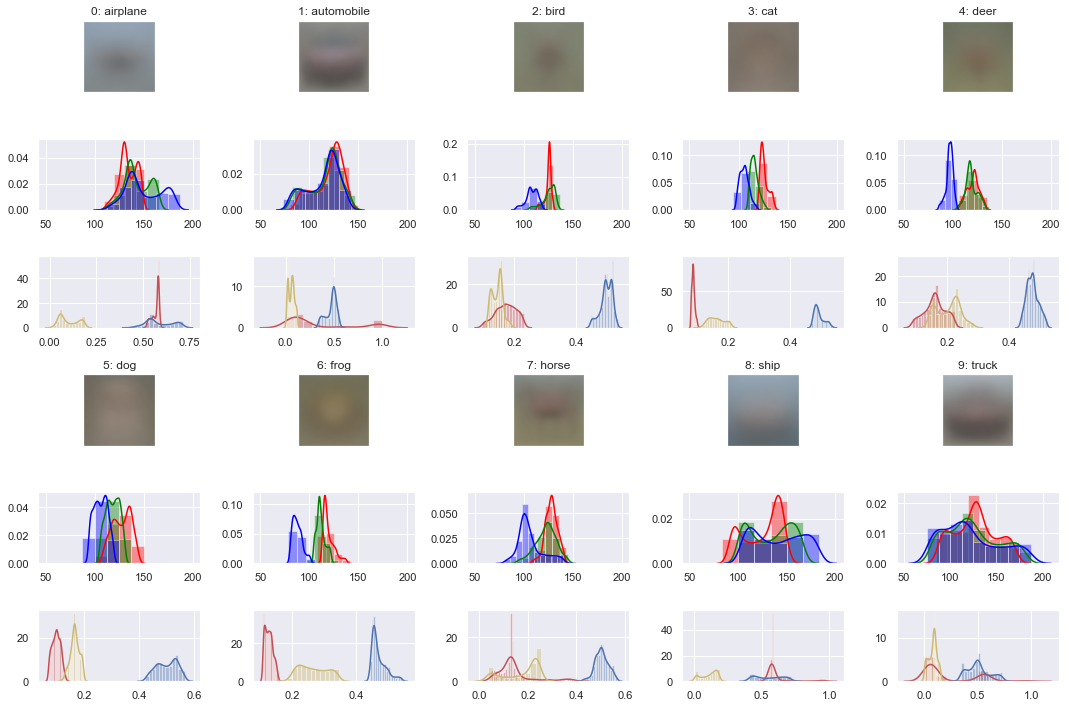

In [12]:
batch = {
    b'data': train_data,
    b'labels': train_labels
}

avg_imgs = plot_avg_imgs(batch, with_histogram=True, with_hsv=True)
plt.tight_layout()
plt.show();

In average images, we can see blurred contours of pictures of each category. For instance, pictures of horse category have a tendency to be taken on the meadow with green grass with the horse being shown from its side.

From the colour histograms, we can observe that colour values, especially G and R channels, are similar for the majority of images. We plot also the distribution of HSV (red=hue, yellow=saturation, blue=value) values, as RGB is a bit misleading - we don't know which R, G, B values are from the same pixel. But they are joined together in the HSV model into _hue_. And so we can see something like a tendency in terms of the hue of the whole image throughout categories.

We will look closer at those similar categories using clustering to identify them.

In [13]:
def plot_dendrogram(model, **kwargs) -> None:
    """Create linkage matrix and then plot the dendrogram
    See https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    :param model: Agglomerative clustering learned model
    :param **kwargs: Passed to scipy dendrogram ploting function
    """
    from scipy.cluster.hierarchy import dendrogram

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

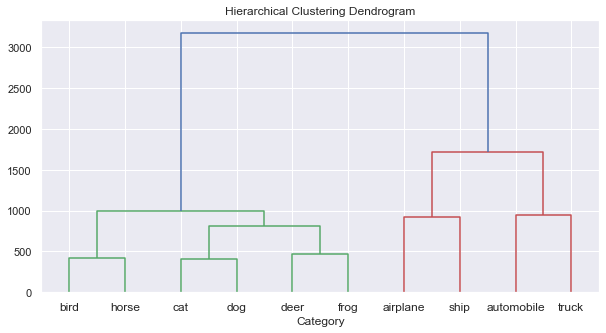

In [14]:
from sklearn.cluster import AgglomerativeClustering

model_ac = AgglomerativeClustering(distance_threshold=0, 
                                   n_clusters=None)
model_ac = model_ac.fit(avg_imgs)

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model_ac, truncate_mode=None,
        labels=[label_names[i] for i in range(10)])
plt.xlabel("Category")
plt.show()

So we expect worse results in distinguishing cats and dogs, airplanes and ships, ... because their clusters are relatively close to each other.

## Picture properties

Another way we can make histograms is to grab all images and plot the histogram corresponding to their RGB values. Due to the large size of the whole dataset, we will examine only the 4<sup>th</sup> root of all samples.

In [15]:
def plot_global_hist(batch, sample_size: int = 50) -> None:
    """
    Histogram of RGB values from whole batch. Take all values into
    account instead of making an average image. But because the
    whole dataset is too large, we use only random subsample of 
    default size of 50 images from each category.
    :param batch: dictionary with images and labels
    :param sample_size: size of random sample of each category
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 8))

    for i in range(10):
        imgs = imgs_of_cat(batch, i)
        imgs = imgs[np.random.choice(imgs.shape[0], sample_size)]
        x, y = i % 5, i // 5

        axs[y][x].set_title(label_names[i])
        plot_rgb_hist(imgs, axs[y][x])

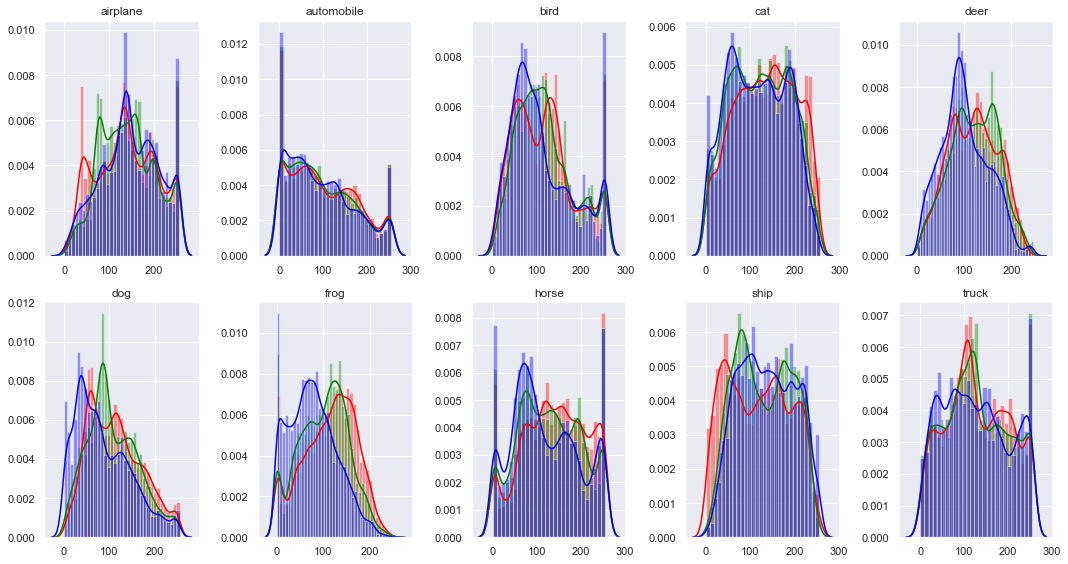

In [16]:
plot_global_hist(batch, sample_size=int(len(train_data) ** 0.25))
plt.tight_layout()

Some histograms have large bin corresponding to RGB (255, 255, 255), which means there is probably white background - like in a portrait and not photo, because in reality there is almost never such "pure" color - maybe these images can be found as outliers.

Also, inspecting the local maxima of the pictures, we can see that some classes tend to be rather darker - with the maxima in lower half of 0-255 interval, e.g. dogs or frogs, which is naturally caused by the environment character they are ussualy find in. On the other hand, classes like airplane or ship, also trucks, are brighter, which again has similar explonation.

## Outliers

As the dataset does not contain outliers that should be removed, we plot the pictures from a random selection of size 1000, which are the least likely to be in their class, which might be caused by properties discussed above.

In [17]:
def plot_images(imgs: np.ndarray) -> None:
    """
    Plots all images given, using matplotlib.pyplot in single row.    
    :param imgs: images in form 1D array [Rvalue, Gvalues, Bvalues]
    """
    width = len(imgs)
    height = 1
    
    fig, axs = plt.subplots(height, width)
    counter = 0
    for ax in np.reshape(axs, -1):
        plot_raw_img(imgs[counter], label=None, ax=ax)
        counter += 1

airplane


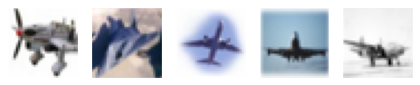

automobile


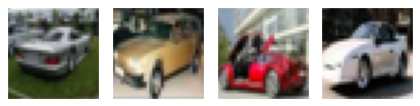

bird


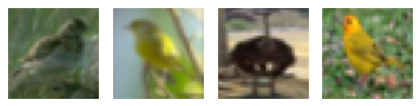

cat


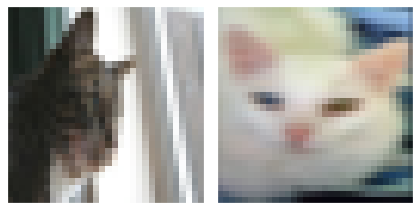

deer


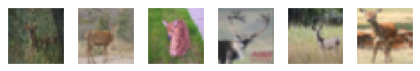

dog


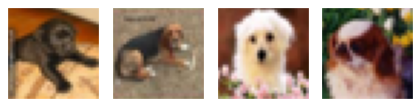

frog


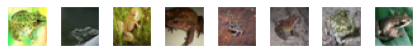

horse


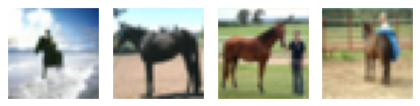

ship


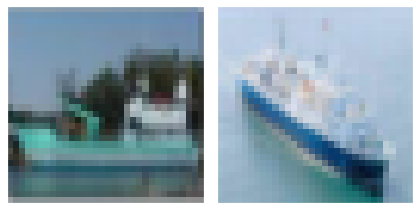

truck


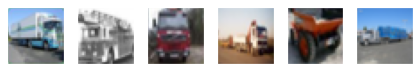

In [18]:
from sklearn.neighbors import LocalOutlierFactor


def detect_outliers(imgs, labels, test_size):
    np.random.seed(0)
    sample = np.random.choice(len(imgs), test_size, replace=False)
    imgs = imgs[sample]
    labels = labels[sample]

    # Scale data. It is simple, every pixel is in range 0-255.
    imgs = imgs / 255

    # Find Outliers using LOF
    LOF = LocalOutlierFactor()
    outliers = np.where(LOF.fit_predict(imgs) == -1)[0]

    for i in range(len(labels)):
        cat_images = train_data[outliers][train_labels[outliers] == i]
        if len(cat_images) == 0:
            continue
        print(label_names[i])
        plot_images(cat_images)
        plt.tight_layout()
        plt.show()
        
    del sample, labels, imgs, outliers


detect_outliers(train_data, train_labels, test_size=1000)

We have found out that there are also images with "unnatural" backgrounds. The pictures made by cropping other picture, like examples in airplane or truck classes, are likely to cause misclassification due to the global character of images of the same class. Also, the dataset contains not very common backgrounds for some images, like in horse or frog class, which again, might cause such instability in the classification.

## Correlation

Finally, we will examine the correlation of each pixel for the data. 

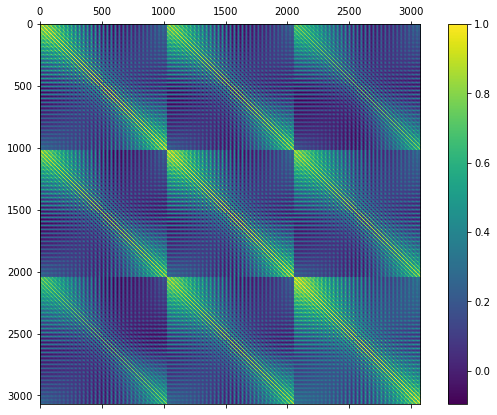

In [19]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(np.corrcoef(train_data.T))
fig.colorbar(cax);

The matrix appears to be divided into 9 zones, which is caused by 3 colour channels in data, R, G, B in this order. It can be seen that the RGB channels are strongly correlated as the diagonal in each zone is bright, with R and G channel correlation being very high.

Values near the main diagonal demonstrate the property of real pictures, i.e. pixels are strongly correlated with nearby pixels. Furthermore, the matrix suggests, that the images are symmetric about the vertical, as, for each square, the submatrix is symmetric about the main diagonal. More precisely, lighter regions in the top left and bottom right corners mean, that the background of the picture is rather symmetrical, the upper part (e.g. sky) and the lower part (e.g. sea).

# Data Pre-processing

Having discussed the properties of the set, we will try to reduce the possibility of misclassification, and reduce the dimension of the features, as there is a high correlation among nearby pixels.

First of all, we transform the data to RGB representation, i.e. to shape (?, 32, 32, 3) so that we can use functions from the skimage (scikit-image) library. To achieve this, we only need to reshape and transpose the data.

In [20]:
def batch_to_rgb(images: np.ndarray) -> np.ndarray:
    """
    Given loaded images from CIFAR-10 dataset (i.e. 32x32 values
    of red, then green and blue), returns same set of images with
    color channel being the last, i.e. batch_to_rgb[n][y][x]
    returns 3-valued array with r, g, b of pixel (x, y) of n-th 
    image.
    :param images: CIFAR-images in default format
    :return: same images with transformed colors to rgb
    """
    return images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

In [21]:
train_data = batch_to_rgb(train_data)
test_data = batch_to_rgb(test_data)
train_data.shape

(50000, 32, 32, 3)

As mentioned above, there are no missing values nor values out of range. Because the range of values for RGB is 0-255, we first transform values to floats and then scale to 0-1 interval.

In [22]:
train_data = train_data / 255.0
test_data = test_data / 255.0

Now, each image has 32 * 32 * 3 = 3,072 features. However, from the correlation matrix we saw, that there are many correlated features, so we will apply two different procedures:

1. [reffering as HSV model] The data will be converted to HSV model. Based on data analysis, especially RGB and HSV histograms, we will save only *hue* part of the colour model. Then we flatten the data and centralise it. To reduce the dimensionality, and also training time, we will apply PCA analysis and will keep transformed data with 95% of the variance;
2. [hog model] We will compute the histogram of oriented gradients of the data with parameters set sensibly, so we do not lose much information and at the same time, we keep as little features as possible. Before however, we will grayscale the data, to reduce dimensionality unnecessary for computing the HOG descriptors.

## HSV Model

For this procedure, we will use functions from the scikit-image and the sklearn library.

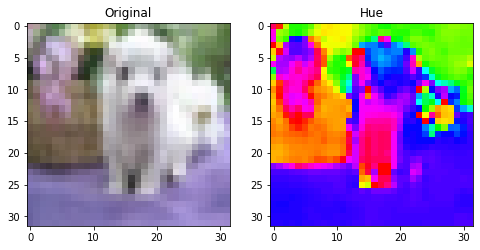

In [23]:
from skimage.color import rgb2hsv


# Convert to hsv, keep hue part
hsv_train = rgb2hsv(train_data)[:, :, :, 0]
hsv_test  = rgb2hsv(test_data )[:, :, :, 0]

# We will demonstrate rgb - hsv comparison
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(train_data[1545])
ax[0].set_title("Original")

ax[1].imshow(hsv_train[1545], cmap='hsv')
ax[1].set_title("Hue");

In [24]:
# Flatten the data
hsv_train = hsv_train.reshape((hsv_train.shape[0], -1))
hsv_test  = hsv_test.reshape((hsv_test.shape[0], -1))

# Centralise by subtracting the mean
mean_image = np.mean(hsv_train, axis=0)
hsv_train -= mean_image
hsv_test  -= mean_image

The resulting data, after applying PCA decomposition with keeping 95% of the variance, has a shape:

In [25]:
from sklearn.decomposition import PCA


pca = PCA(
    n_components=0.95,  # keep at least 95% of variance
    svd_solver='full',  # given by previous
)

hsv_train = pca.fit_transform(hsv_train)
hsv_test  = pca.transform(hsv_test)
hsv_train.shape

(50000, 587)

## HOG Model

Again, we will use functions the from scikit-image library, namely *hog()* and *rgb2gray()*.

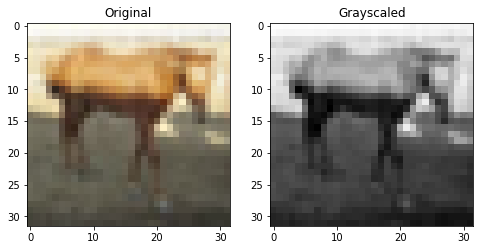

In [26]:
from skimage.color import rgb2gray


# Convert to grayscale
hog_train = rgb2gray(train_data)
hog_test  = rgb2gray(test_data)

# Display difference
horse = train_data[2000]
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(horse)
ax[0].set_title("Original")

horse_gray = hog_train[2000]
ax[1].imshow(horse_gray, cmap='gray')
ax[1].set_title("Grayscaled");

As for computing the HOG, we will use 4 cells for normalisation of blocks, and 64 pixels per cell. As we aim to have fast-learning model, this choice ensures that we will get a relatively small amount of features, but we will still preserve high accuracy, as, by this choice, we will concentrate more on edges of larger objects rather than small details.

In [27]:
from skimage.feature import hog
from joblib import Parallel, delayed


# Converts to hog one picture
def to_hog(picture):
    return hog(picture, cells_per_block=(2, 2), pixels_per_cell=(8, 8))


# Convert to hog
hog_train = np.asarray(
    Parallel(n_jobs=-1, batch_size=1000)(delayed(to_hog)(x) for x in hog_train)
)
hog_test = np.asarray(
    Parallel(n_jobs=-1, batch_size=1000)(delayed(to_hog)(x) for x in hog_test)
)

Again, we will show the difference between the transformed picture and the original:

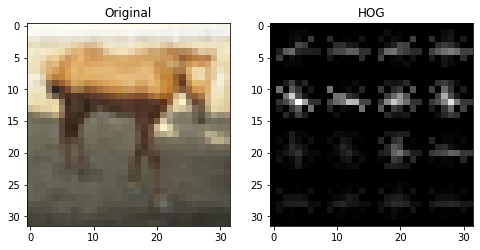

In [28]:
_, hog_horse = hog(horse_gray, cells_per_block=(2, 2), 
                   pixels_per_cell=(8, 8), visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(horse)
ax[0].set_title("Original")

ax[1].imshow(hog_horse, cmap='gray')
ax[1].set_title("HOG");

where we can see the edges of the horse. Even it might be harder to identify a horse on the HOG image, compared to the original image, we can see that only the most important parts are preserved. The resulting data has a shape

In [29]:
hog_train.shape

(50000, 324)

which is almost two times less than in the HSV model, and about ten times less than in the original set.

In [30]:
# Eventually we can clean in-future-unused variables
del train_data

# Introducing and Tunning the Models

As the structure and semantics of the data from two preprocessing steps are different, we will train models for each of the prepared training sets. To achieve high performance, we will first tune hyperparameters of the proposed models.

## Baseline Model

As we aim to produce a simple model so for the baseline model we will not use neural network models. We chose DecisionTree from the sklearn library and we will tune its parameters for both preprocessing models using the RandomizedSearchCV algorithm, which allows us to pick from many parameters, although it does not try them all.

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

For both runs, we will tune *used method*, *number of features* used, *maximal depth* and requirements for the creation of new nodes - as these are the parameters expected to have the highest impact on learning, from this grid:

In [32]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_features": [None, "auto", "log2"],
    "max_depth": [20, 50, 100, 200, 300],
    "min_samples_split": [10, 100, 500, 1000],
    "min_samples_leaf": [10, 100, 200, 500, 1000]
}

### HSV Model

In [33]:
grid_search_tree_hsv = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    n_iter=20,                        # We will cover 20/600 = 1/30 options out of all options
    scoring="accuracy",               # Our aim is to max the accuracy
    n_jobs=-1,                        # Use all computing power
    cv=5,                             # Use 5-fold crossvalidation
    refit=True,                       # To extract parameters of learning
    verbose=4,
    random_state=42,
)

grid_search_tree_hsv.fit(hsv_train, train_labels)
hsv_tree = grid_search_tree_hsv.best_estimator_  # Save the best estimator

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished


As we used 5-fold validation in a grid search, we can estimate the average accuracy of the best DecisionTree trained as:

In [34]:
grid_search_tree_hsv.best_score_

0.27758

This classifier has the parameters equal to:

In [35]:
grid_search_tree_hsv.best_params_

{'min_samples_split': 500,
 'min_samples_leaf': 200,
 'max_features': None,
 'max_depth': 20,
 'criterion': 'gini'}

### HOG Model

In [36]:
grid_search_tree_hog = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    n_iter=20,                        # We will cover 20/600 = 1/30 options out of all options
    scoring="accuracy",               # Our aim is to max the accuracy
    n_jobs=-1,                        # Again use all processing units
    cv=5,                             # Use 5-fold crossvalidation
    refit=True,
    verbose=4,
    random_state=42,
)

grid_search_tree_hog.fit(hog_train, train_labels)
hog_tree = grid_search_tree_hog.best_estimator_  # Save the best estimator

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


On this dataset (train set), after the cross-validation, the best decision tree was able to achieve average accuracy:

In [37]:
grid_search_tree_hog.best_score_

0.30672

with parameters being:

In [38]:
grid_search_tree_hog.best_params_

{'min_samples_split': 100,
 'min_samples_leaf': 10,
 'max_features': None,
 'max_depth': 200,
 'criterion': 'gini'}

## k Nearest Neighbours

We have decided on the KNN model, as it is one of the simplest models in machine learning. It does not "learn" anything, because all it does is storing every object from the training set, and during prediction phase, it finds $k$ nearest neighbours - $k$ nearest objects from training set using specified metric. Then they vote for the predicted category, with (not necessarily)
different weights. Category with the strongest total vote becomes the result.

In [39]:
from sklearn.neighbors import KNeighborsClassifier

Due to a large number of samples in the training data and time complexity of this algorithm (we will set the algorithm to *ball_tree* to have defined the complexity in advance) being $\mathcal{O}(d*log(n))$, where $d$ is the number of features and $n$ number of samples, we will tune hyperparameters for this algorithm only on a subset of data with size being 10% (which corresponds to 5,000 pictures).

In [40]:
from sklearn.utils import resample


sample_X_hsv, sample_y_hsv = resample(
    hsv_train, train_labels,
    replace=False,                       # forbid picking same sample multiple times 
    n_samples=hsv_train.shape[0] // 10, 
    random_state=42,
    stratify=train_labels                # pick sample with labels proportional to train set
)

sample_X_hog, sample_y_hog = resample(
    hog_train, train_labels,
    replace=False, 
    n_samples=hog_train.shape[0] // 10, 
    random_state=42,
    stratify=train_labels
)

We are going to tune 3 hyperparameters:

1. n_neighbours: number of neighbours to check for voting,
2. weights: it seems reasonable to influence the predicted class label more by nearer images (in vector space), but we will test if we are right;
3. metric for computing distance. We use Minkowski metrics formula $\sum(|x - y|^p)^{(1/p)}$ whereby adjusting the parameter $p$, one gets also the Manhattan and the Euclidean metrics. Setting $p$ to higher values than 3 is not very common.

In [41]:
param_grid = {
    'n_neighbors': [10, 12, 15, 20, 30, 45, 60, 78, 100],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

# which gives us totally 9 * 2 * 3 = 54 training options

### HSV Model

In [42]:
grid_search_knn_hsv = RandomizedSearchCV(
    KNeighborsClassifier(algorithm="ball_tree"),
    param_distributions=param_grid,
    n_iter=40,                        # We will cover 40/54 options out of all options
    scoring="accuracy",               # Our aim is to max the accuracy
    n_jobs=-1,
    cv=5,                             # Use 5-fold crossvalidation
    refit=True,
    verbose=4,
    random_state=42,
)

grid_search_knn_hsv.fit(sample_X_hsv, sample_y_hsv)
hsv_knn = grid_search_knn_hsv.best_estimator_  # Save the best estimator

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.9min finished


The mean cross-validated score of the best_estimator found by this search is

In [43]:
grid_search_knn_hsv.best_score_

0.2604

and the parameters of the best estimator:

In [44]:
grid_search_knn_hsv.best_params_

{'weights': 'distance', 'p': 3, 'n_neighbors': 12}

### HOG Model

In [45]:
grid_search_knn_hog = RandomizedSearchCV(
    KNeighborsClassifier(algorithm="ball_tree"),
    param_distributions=param_grid,
    n_iter=40,                        # use same number of iterations as in hsv model
    scoring="accuracy",               # Our aim is to max the accuracy
    n_jobs=-1,
    cv=5,                             # Use 5-fold crossvalidation
    refit=True,
    verbose=4,
    random_state=42,
)

grid_search_knn_hog.fit(sample_X_hog, sample_y_hog)
hog_knn = grid_search_knn_hog.best_estimator_  # Save the best estimator

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 10.4min finished


Our best model was able to achieve mean accuracy

In [46]:
grid_search_knn_hog.best_score_

0.47919999999999996

with best parameters

In [47]:
grid_search_knn_hog.best_params_

{'weights': 'distance', 'p': 1, 'n_neighbors': 30}

## SVM

As for the second classifier, we chose Support Vector Machines. This algorithm aims to find the hyperplanes in feature space which distinct the data points most accurately. The hyperplane should have the maximal distance from the samples of the classes they separate, to generalise the data and add more confidence to predictions. The support vectors denote the points that define the hyperplanes. The SVM is a linear classifier which given sample to be predicted, finds the subspace to which it belongs based on the hyperplanes, and assigns label accordingly.

We chose to classify by the sklearn.SVC model to explore different kernels used. As the time and space complexity of this model is quadratic in the number of samples, and the model tends to overfit, we will create an ensemble of these models using a BaggingClassifier. This way, the SVC will learn only on a subset of the data, and more SVC models will be trained, leading to less likelihood of overfitting model, and, hopefully, better generalisation.

In [48]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

To tune the hyperparameters, we will first tune the SVC hyperparameters on the subset of the data used in the KNN model, then we will examine the best parameters for the BaggingClassifier. For the SVC, we will tune:

1. C regularisation parameter: the size of the margin between hyperplanes;
2. kernel: we will examine radial or linear kernel options;
3. gamma: influence of single point on the created hyperplane in the RBF kernel;
4. tol: the tolerance for stopping. We believe this might influence the generalisation of the algorithm.

For the BagginClassifier, we will tune the obvious parameters:

1. n_estimators: number of estimators used
2. max_samples: the maximal size of a subset each estimator learns from - the single estimator might specialise on a small number of images, but the ensemble will choose the category by the “public vote”.

We will adjust the iterations of RandomizedSearchCV to equalise the time spent by learning with the KNN model.

In [49]:
svc_param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
    "tol": [1e-4, 1e-3, 1e-2, 1e-1]
}

# Totalling 6 * 2 * 6 * 4 = 288 different options


bagging_param_grid = {
    "n_estimators": [6, 8, 10, 12, 15, 16],
    "max_samples": [0.05, 0.08, 0.1, 0.15, 0.18],
}

# 6 * 5 = 30 options for bagging classifier

### HSV Model

In [50]:
grid_search_svc_hsv = RandomizedSearchCV(
    SVC(cache_size=800),
    param_distributions=svc_param_grid,
    n_iter=15,                        # We will do only 15 iterations due to time complexity
    scoring="accuracy",               # Our aim is to max the accuracy
    n_jobs=-1,
    cv=5,                             # Use 5-fold crossvalidation
    refit=True,
    verbose=4,
    random_state=42,
)

grid_search_svc_hsv.fit(sample_X_hsv, sample_y_hsv);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 12.4min finished


The best model was able to achieve the accuracy

In [51]:
grid_search_svc_hsv.best_score_

0.302

with the parameters set to

In [52]:
grid_search_svc_hsv.best_params_

{'tol': 0.01, 'kernel': 'rbf', 'gamma': 0.01, 'C': 10}

Although the current classifier might be overfitted, by using the BaggingClassifier with multiple SVCs, we will reduce this negative effect

In [53]:
# Specify the best 
best_svc = SVC(cache_size=800, **grid_search_svc_hsv.best_params_)


grid_search_bag_hsv = RandomizedSearchCV(
    BaggingClassifier(best_svc),
    param_distributions=bagging_param_grid,
    n_iter=20,                        # We picked 20, so model explored 2/3 of combinations, still quickly
    scoring="accuracy",               # Our aim is to max the accuracy
    n_jobs=-1,
    cv=5,                             # Use 5-fold crossvalidation
    refit=True,
    verbose=4,
    random_state=42,
)

grid_search_bag_hsv.fit(sample_X_hsv, sample_y_hsv)
best_bagginng_hsv = grid_search_bag_hsv.best_estimator_  # Save the best estimator

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


On hsv preprocessed data, this model was able to achieve mean cross-validated accuracy of

In [54]:
grid_search_bag_hsv.best_score_

0.2952

with best parameters

In [55]:
grid_search_bag_hsv.best_params_

{'n_estimators': 15, 'max_samples': 0.18}

### HOG Model

In [56]:
grid_search_svc_hog = RandomizedSearchCV(
    SVC(cache_size=800),
    param_distributions=svc_param_grid,
    n_iter=15,                        # Again, due to time complexity
    scoring="accuracy",               # Our aim is to max the accuracy
    n_jobs=-1,
    cv=5,                             # Use 5-fold crossvalidation
    refit=True,
    verbose=4,
    random_state=42,
)

grid_search_svc_hog.fit(sample_X_hog, sample_y_hog);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.7min finished


With the accuracy of

In [57]:
grid_search_svc_hog.best_score_

0.5058

and best parameters

In [58]:
grid_search_svc_hog.best_params_

{'tol': 0.1, 'kernel': 'rbf', 'gamma': 0.1, 'C': 100}

Now, we will train the BaggingClassifier:

In [60]:
best_svc = SVC(cache_size=800, **grid_search_svc_hog.best_params_)


grid_search_bag_hog = RandomizedSearchCV(
    BaggingClassifier(best_svc),
    param_distributions=bagging_param_grid,
    n_iter=20,                        
    scoring="accuracy",               # Our aim is to max the accuracy
    n_jobs=-1,
    cv=5,                             # Use 5-fold crossvalidation
    refit=True,
    verbose=4,
    random_state=42,
)

grid_search_bag_hog.fit(sample_X_hog, sample_y_hog)
best_bagginng_hog = grid_search_bag_hog.best_estimator_  # Save the best estimator

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


This model achieved the cross-validated accuracy

In [61]:
grid_search_bag_hog.best_score_

0.4896000000000001

with following parameters

In [62]:
grid_search_bag_hog.best_params_

{'n_estimators': 15, 'max_samples': 0.15}

# Training and Evaluation of Models

In this section, we will train the best models on the whole training set, predict and evaluate the models, and measure the total time spent by training and prediction of the KNN and the SVM models. For evaluation, we will use *accuracy*, which is the fraction of correctly classified samples to all classified samples, as we are interested in the fact, how many images were classified correctly.

For the KNN and the SVM classificator, we will also print some misclassified pictures and the confusion matrices.

In [80]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from time import time

## Baseline Classifier

For the baseline classifier, we will evaluate only the accuracy, as we do not, and it is not the aim of this project, intend to explain the reasons of misclassifications, as this is a baseline model.

### HSV Model

In [64]:
# The fit overwrites previously learnt data
hsv_tree.fit(hsv_train, train_labels)

# Predict on test data
hsv_tree_predictions = hsv_tree.predict(hsv_test)

# Print accuracy score
accuracy_score(test_labels, hsv_tree_predictions)

0.2885

### HOG Model

In [65]:
# The fit overwrites previously learnt data
hog_tree.fit(hog_train, train_labels)

# Predict on test data
hog_tree_predictions = hog_tree.predict(hog_test)

# Print accuracy score
accuracy_score(test_labels, hog_tree_predictions)

0.3141

### Summary

The baseline DecisionTree model achieved accuracy ≈29% on the HSV model, and ≈31% on the HOG model, even the feature space was smaller. We will use these results to compare the other models.

## KNN Classifier

### HSV Model

In [67]:
# Measure time
start = time()

# Fit the best model with the whole data set
hsv_knn.set_params(n_jobs = -1)
hsv_knn.fit(hsv_train, train_labels)

# Predict the test set
hsv_knn_predictions = hsv_knn.predict(hsv_test)

knn_hsv_time = time() - start

This model was able to achieve the overall accuracy of

In [68]:
accuracy_score(test_labels, hsv_knn_predictions)

0.2999

in time (seconds):

In [69]:
knn_hsv_time

1311.8339591026306

### HOG Model

In [70]:
# Measure time
start = time()

# Fit the best model with the whole data set
hog_knn.set_params(n_jobs = -1)
hog_knn.fit(hog_train, train_labels)

# Predict the test set
hog_knn_predictions = hog_knn.predict(hog_test)

knn_hog_time = time() - start

With different preprocessing steps, the same algorithm was able to achieve the accuracy

In [71]:
accuracy_score(test_labels, hog_knn_predictions)

0.5474

in time (seconds):

In [72]:
knn_hog_time

101.36638045310974

### Summary

This model is more accurate than the baseline model in both preprocessing methods, but in the HSV model - the accuracy change is only small (1%). Again, the model achieved higher accuracy on the HOG model, which means, the data might have been preprocessed better. The learning time for the HOG model was much smaller than in the HSV model, which might be explained by the size of feature space, and thus memory being virtualised on disk.

## SVM Classifier

### HSV Model

In [73]:
# Measure time
start = time()

# Fit the best model with the whole data set
best_bagginng_hsv.set_params(n_jobs = -1, verbose = 20)
best_bagginng_hsv.fit(hsv_train, train_labels)

# Predict the test set
hsv_bagging_predictions = best_bagginng_hsv.predict(hsv_test)

bagging_hsv_time = time() - start

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  9.1min remaining: 27.4min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  9.2min remaining: 15.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  9.2min remaining:  9.2min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  9.2min remaining:  5.5min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  9.2min remaining:  3.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  9.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  6.0min remaining: 18.1min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  6.0min remaining: 10.0min
[Parallel(n_jobs=8

When preprocessed with the HSV Model, the SVM Bagging Classifier achieved the accuracy

In [74]:
accuracy_score(test_labels, hsv_bagging_predictions)

0.3445

in time

In [75]:
bagging_hsv_time

918.4064607620239

As we discussed the possibility of overfitting, we will check the accuracy of the model on the train data:

In [136]:
hsv_bagging_overfit_check = best_bagginng_hsv.predict(hsv_train)
accuracy_score(train_labels, hsv_bagging_overfit_check)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 16.7min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 31.2min remaining: 93.5min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed: 31.2min remaining: 52.0min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed: 31.2min remaining: 31.2min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 31.2min remaining: 18.7min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed: 31.2min remaining: 10.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 31.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 31.3min finished


0.4493

### HOG Model

In [76]:
# Measure time
start = time()

# Fit the best model with the whole data set
best_bagginng_hog.set_params(n_jobs = -1, verbose = 20)
best_bagginng_hog.fit(hog_train, train_labels)

# Predict the test set
hog_bagging_predictions = best_bagginng_hog.predict(hog_test)

bagging_hog_time = time() - start

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.9min remaining:  8.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.9min remaining:  4.8min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.9min remaining:  2.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.9min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.9min remaining:   58.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.6min remaining:  7.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.6min remaining:  4.4min
[Parallel(n_jobs=8

With accuracy

In [77]:
accuracy_score(test_labels, hog_bagging_predictions)

0.5949

in time

In [78]:
bagging_hog_time

333.9712595939636

Again, we will check the accuracy on the training set to examine the overfitting:

In [137]:
hog_bagging_overfit_check = best_bagginng_hog.predict(hog_train)
accuracy_score(train_labels, hog_bagging_overfit_check)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 13.6min remaining: 40.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed: 13.6min remaining: 22.7min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed: 13.7min remaining: 13.7min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 13.7min remaining:  8.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed: 13.7min remaining:  4.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 13.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 13.7min finished


0.65986

### Summary

The SVC model achieved the accuracy of ≈34% on the HSV model and ≈59% on the HOG model, which compared to previous models, is the best result (the KNN achieved 30% and 54%, baseline only 29% and 31%). However, the training time for the best (HOG) model was 3 times higher than the training time for the best (HOG) KNN model, with only ≈5% of accuracy increase.

The SVC model tends to overfit, but by using the BaggingClassifier we minimalised this effect. However, the slight overfitting on the data is still present (on the HSV model the difference between predicting the test and the train set is 10%, for the HOG model 6%). Therefore, the model could do better with a larger dataset, or by increasing the SVC models count in the BaggingClassifier, which would lead to worse learning and prediction time.

## Misclassifications

In this part, we will plot the confusion matrices and misclassified pictures. As the hog preprocessing method did better in the evaluation phase, we will concentrate on hog preprocessing method more.

In [129]:
def display_misclassifications(pictures, y_true, y_pred):
    """
    Displays misclassified pictures from each category
    
    :param pictures rgb scaled pictures
    :param y_true true labels
    :param y_pred predicited labels
    """
    fig, ax = plt.subplots(10, 10, figsize=(15, 15))
    for correct in range(10):  # over all categories
        for bad in range(10):
            ax[correct][bad].axis('off')        
            if bad == correct:
                ax[correct][bad].text(0.3, 0.5, label_names[correct])
                continue
            missed_cat = pictures[(y_pred == bad) & (y_true == correct)]
            if missed_cat.size == 0:
                continue
            ax[correct][bad].imshow(missed_cat[0])
    plt.tight_layout()

### K Nearest Neighbours

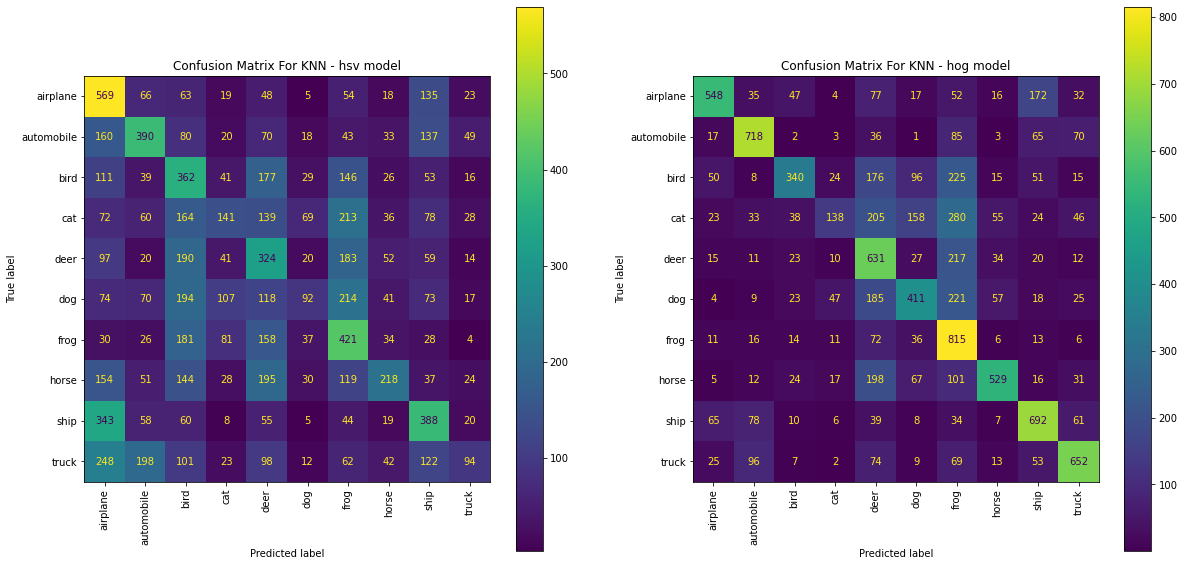

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))


ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(test_labels, hsv_knn_predictions),
    display_labels=label_names
).plot(
    xticks_rotation='vertical',
    ax=ax[0],
    values_format=''
)

ax[0].set_title("Confusion Matrix For KNN - hsv model");


ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(test_labels, hog_knn_predictions),
    display_labels=label_names
).plot(
    xticks_rotation='vertical',
    ax=ax[1],
    values_format=''
)

ax[1].set_title("Confusion Matrix For KNN - hog model");

In both pre-processing methods, there was a significant error in predictions of cats and dogs. Categories deer and frog were predicted with high accuracy, but there was reciprocal error still present. In the HSV model, we can see that the highest prediction error per class is for airplanes and ships - as we discussed in the exploratory analysis, these categories have very similar properties. Also, the model was not able to predict classes dog, cat and truck properly, which might be caused by losing information in the only-hue-preserving HSV transformation and application of the PCA.

On the contrary, the KNN algorithm for the HOG model did better, correctly classifying the majority of pictures. But still, the cat category was not classified properly. As discussed, the model made errors in predictions of ships and airplanes, but the worst error was in misclassification of cats as frogs, which might be explained by the similarity of these objects on photographs - both are usually rounded, of the same shape and size.

There is a plenty of wrongly classified images, but we can, at least, show some of them. Follows 10x10 grid of those images, with true labels in rows and predicted in columns (for the HOG model in preprocessing, the KNN model in predictions).

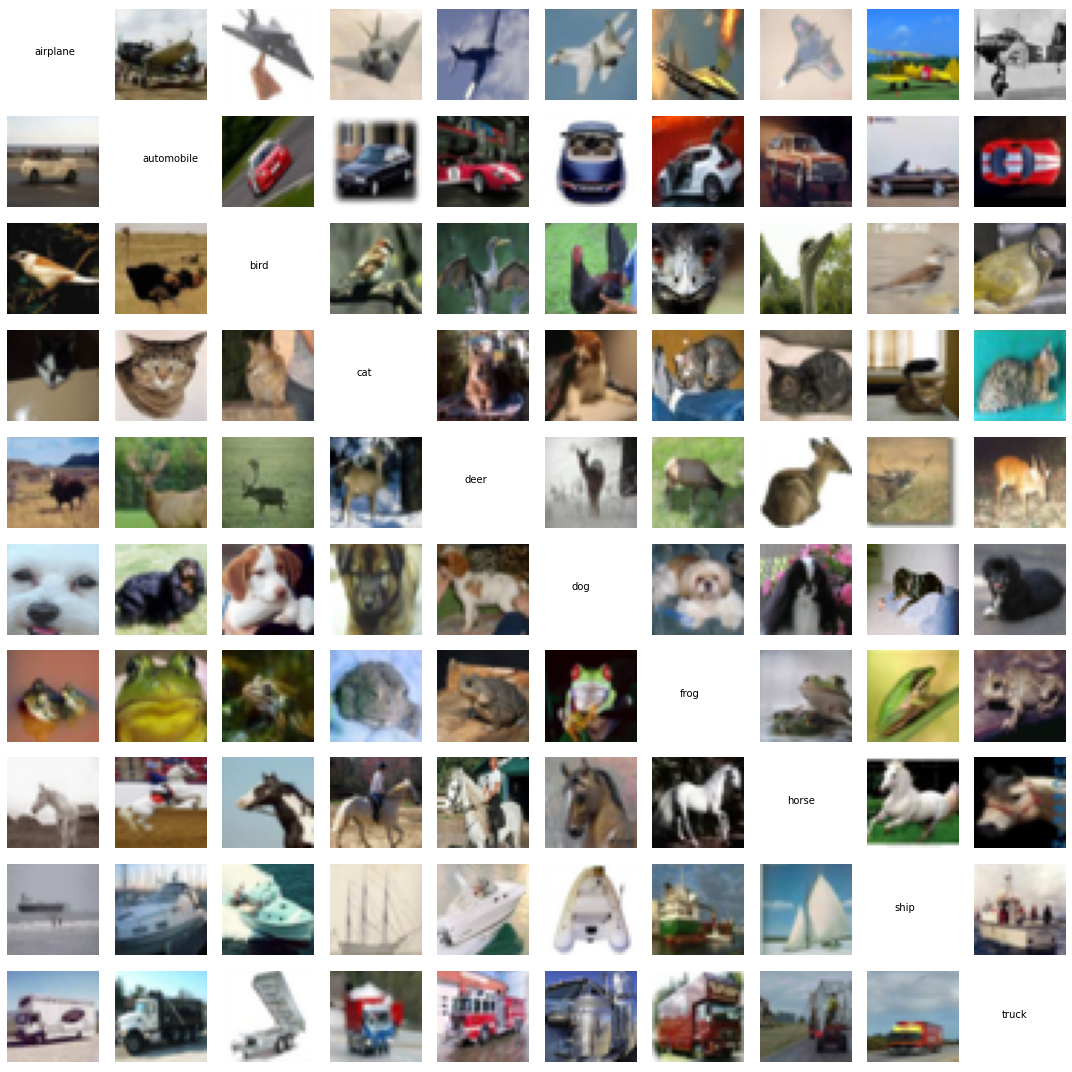

In [130]:
display_misclassifications(test_data, test_labels, hog_knn_predictions)

We can see, that the misclassified pictures tend to have different shapes than the average image of the category. Also, we can find here discussed cropped images - which might be a result of the lack of background information for the classifier. As this classifier did not consider colours, the pictures which would be easily classified based on the colour (e.g. frog in dogs classes) were classified wrongly due to their shape.

### SVM

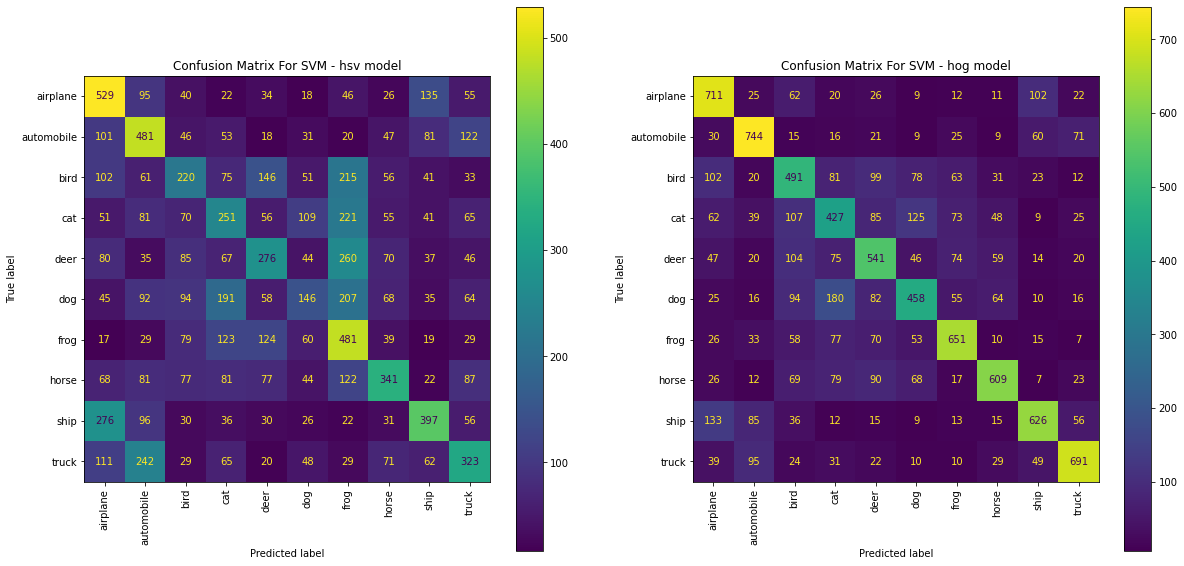

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))


ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(test_labels, hsv_bagging_predictions),
    display_labels=label_names
).plot(
    xticks_rotation='vertical',
    ax=ax[0],
    values_format=''
)

ax[0].set_title("Confusion Matrix For SVM - hsv model")


ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(test_labels, hog_bagging_predictions),
    display_labels=label_names
).plot(
    xticks_rotation='vertical',
    ax=ax[1],
    values_format=''
)

ax[1].set_title("Confusion Matrix For SVM - hog model");

In the HSV model, the SVM classifier made mistakes in distinguishing airplanes and ships, frogs and deers, frogs and birds... as expected - all the pairs close to each other in the dendrogram. The classifier performed exceptionally well in classifying airplanes, which might be caused by the lighter colours of airplanes.

The SVM for the HOG pre-processing model, classifying almost 60% of images correctly, did misclassify dogs and cats as expected, probably due to the same shapes. There is also roughly 12% misclassification error of airplanes and ships. But in general, as the diagonal of this matrix is very bright, the classifier either classified correctly or did not do systematic errors. The class with the highest accuracy was cars, which might be caused by the characteristic shape of cars.

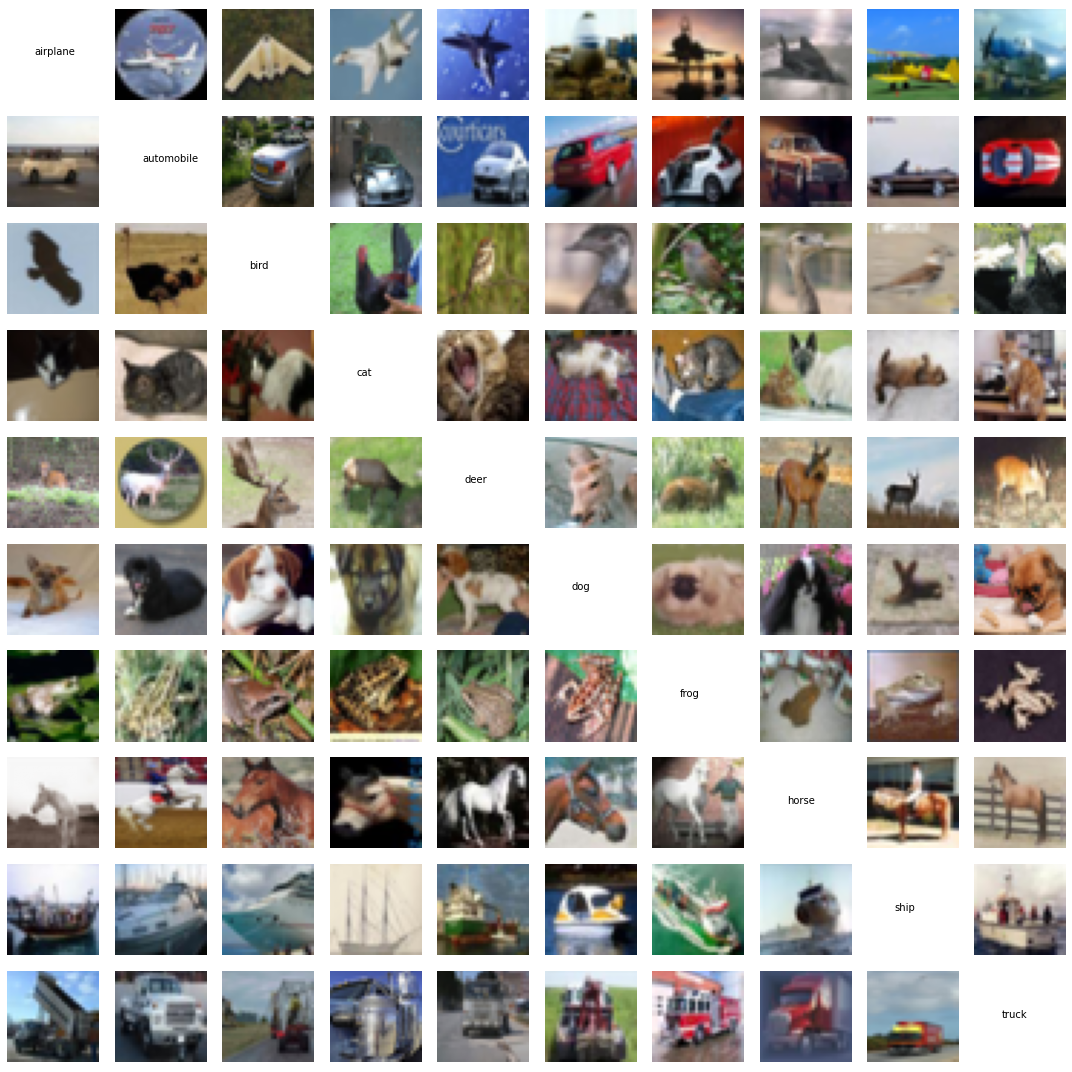

In [131]:
display_misclassifications(test_data, test_labels, hog_bagging_predictions)

We can see similarities with the previous set of images for the KNN, namely in wrong predicted cars as airplanes, or as trucks. But again, the misclassified pictures tend to have different shapes. We can see that many dissimilar pictures were classified for the class of trucks, which might mean the classifier is too general for this class. Also, the presence of the pictures of the horse in the truck category can be explained by taking also the silhouette of the fence into account - as it is striking in the picture.

# Conclusion

To summarise, we tried to classify the CIFAR-10 images with simple models, using two different approaches in pre-processing. It showed up, that transforming to HSV colour model and preserving only the hue part loses a lot of information, as all the models trained on the pictures pre-processed this way did remarkably worse. Using hog descriptors generally performs better than extracting hue before applying PCA, because some categories are very similar in terms of hue. Taking the average images into account, in confusion matrices can be noticed that ships and airplanes were hard to distinguish. Overall, hue tends to be blue in both categories, and so there is not much difference when classifying based on the colours.

Therefore, from the two examined methods, the better one is pre-processing using hog descriptors. Considering the training time, this method leads to more accurate and fast-learning models.

The major problem when classifying this dataset was the size of the dataset. We were not able to tune the hyperparameters on the whole dataset. This also implied the inability to pre-process the data with more complex pre-processing methods, possibly leading to more accurate results. Consequently, the important step was to extract data-characterising features not only for better results but also for reducing the number of features.

From the two models we used, the SVM model with bagging ensemble algorithm performed better on the test set. Both, the KNN and SVM model, were able to achieve higher accuracy than the baseline model, with accuracy on the data pre-processed with hog gradients being above 54%. Even if the algorithms might be similar, with both models trying to split the space to classify the images, the SVM model, despite showing slight overfitting, achieved higher accuracy in a shorter time.

The reason may be that the SVM is not so sensitive to outliers in a dataset and bad feature selection, which was the case, as the dataset has a great variability of categories, with many samples being much different from the average of the corresponding category, and it is challenging to apply the pre-processing method that keeps all the information alongside with reducing feature space to speed the training process up. What stands against KNN is also the curse of dimensionality. Even after pre-processing, there were still many features and therefore even close points (images) were treated as being further away.

To improve achieved results, more sophisticated methods might have been employed in pre-processing and classification of the data. As we tried to train simple and learning models, dropping the information led to lower accuracy. Also tuning the parameters on so small subset of the data dropped the accuracy, especially for the SVM. Hog descriptors applied to grayscaled images do not contain information about colour, which may help in some cases as seen from average images shown earlier and misclassified images above. There was quite a high number of intra-class variations, objects may be depicted from any view, cropped or shifted. In some pictures, there is even more than one object in a picture. Perhaps some kind of foreground extraction would help. Usually, neural networks are used to obtain better results.